# Boosting in Cox Regression

## Load libraries

In [1]:
## load the required packages

# clear all workspace
rm(list=ls()) 
# install the necessary packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")


Attaching package: ‘mlr3extralearners’


The following object is masked from ‘package:mlr3learners’:

    LearnerClassifNnet


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: paradox


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: parallel

Loading required package: stabs

Loading required package: survival

Loading required package: Matrix

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mboost’:

    %+%


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()     masks mboost::%+%()
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks M

## Create the task for d1

In [2]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [3]:
# get the corresponding dataframe1
train_data_d1 <- train_data_original$d1

In [4]:
## create the corresponding task as for dataframe 1
tsks_train_d1 <- TaskSurv$new("df1", backend = train_data_original[[1]], time = "time", event = "status")
## check the task
tsks_train_d1

<TaskSurv:df1> (280 x 17)
* Target: time, status
* Properties: -
* Features (15):
  - dbl (11): V10, V11, V12, V13, V14, V3, V5, V6, V7, V8, V9
  - int (3): V1, V15, V2
  - fct (1): V4

## Hyperparameter Tuning for `d1`


#### Step 1: Boosting with the AFT model

Step 1_1: Try with a default setting

In [5]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_train_d1,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design)

INFO  [20:26:18.425] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [20:26:18.596] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [20:26:19.226] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [20:26:19.748] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [20:26:20.364] [mlr3]  Finished benchmark 


In [6]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.848

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x555f8ada6fa8>,df1,surv.mboost,cv,3,0.847613


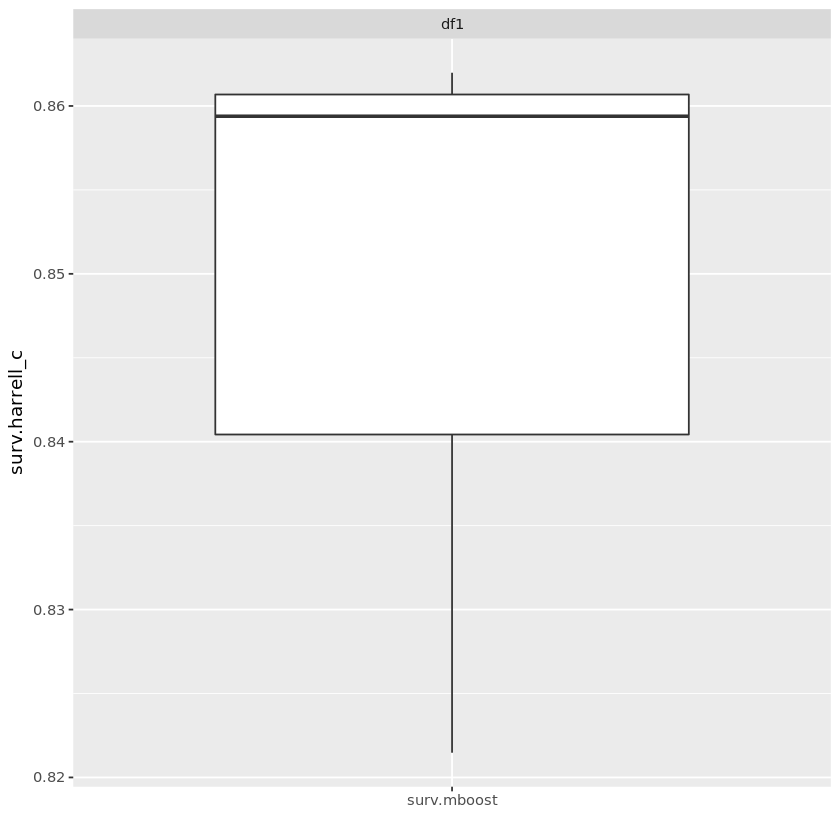

In [7]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [16]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_train_d1, grid_auto_aft, outer_rsmp, store_models = TRUE)

INFO  [20:48:32.782] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df1' (iter 2/3) 
INFO  [20:48:32.815] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [20:48:32.819] [bbotk] Evaluating 1 configuration(s) 
INFO  [20:48:32.845] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [20:48:32.854] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [20:48:34.113] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [20:48:35.378] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [20:48:36.668] [mlr3]  Finished benchmark 
INFO  [20:48:36.712] [bbotk] Result of batch 1: 
INFO  [20:48:36.715] [bbotk]  baselearner family mstop  nu surv.harrell_c 
INFO  [20:48:36.715] [bbotk]        btree loglog    50 0.5      0.7955971 
INFO  [20:48:36.715] [bbotk]                                 uhash 
INFO  [20:48:36.715] [bbotk]  4bcd5dc8-89b8-4d9b-a1f1-843e765420eb 
INFO 

Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning 

In [17]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.832

surv.harrell_c 
     0.8315503

In [18]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[2]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "lognormal"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 50

[[1]]$nu
[1] 0.3875

Step 1_3: Autoplot the pre and after tuning boxplots

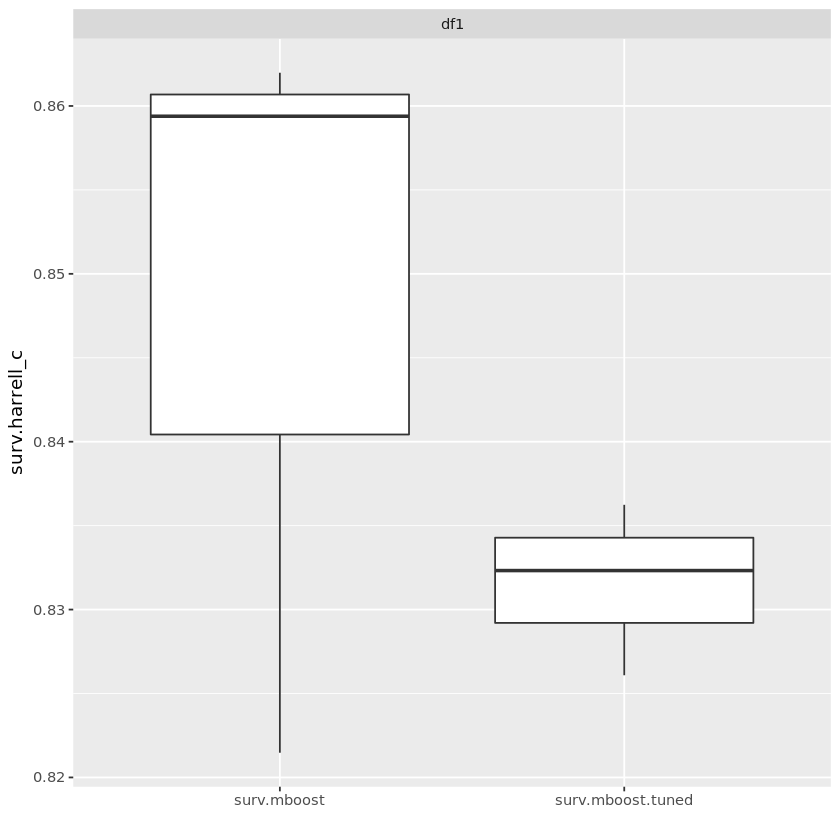

In [19]:
# autoplot the two boxplots
autoplot(c(aft_bmr, aft_bmr_2))

#### Step 2: mboost
Step 2_1: Try with a default setting

In [20]:
design <- benchmark_grid(
  tasks = tsks_train_d1,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [21:00:18.751] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [21:00:18.762] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [21:00:20.053] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [21:00:21.241] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [21:00:22.366] [mlr3]  Finished benchmark 


In [21]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.847

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x555f8afa5578>,df1,surv.mboost,cv,3,0.8468956


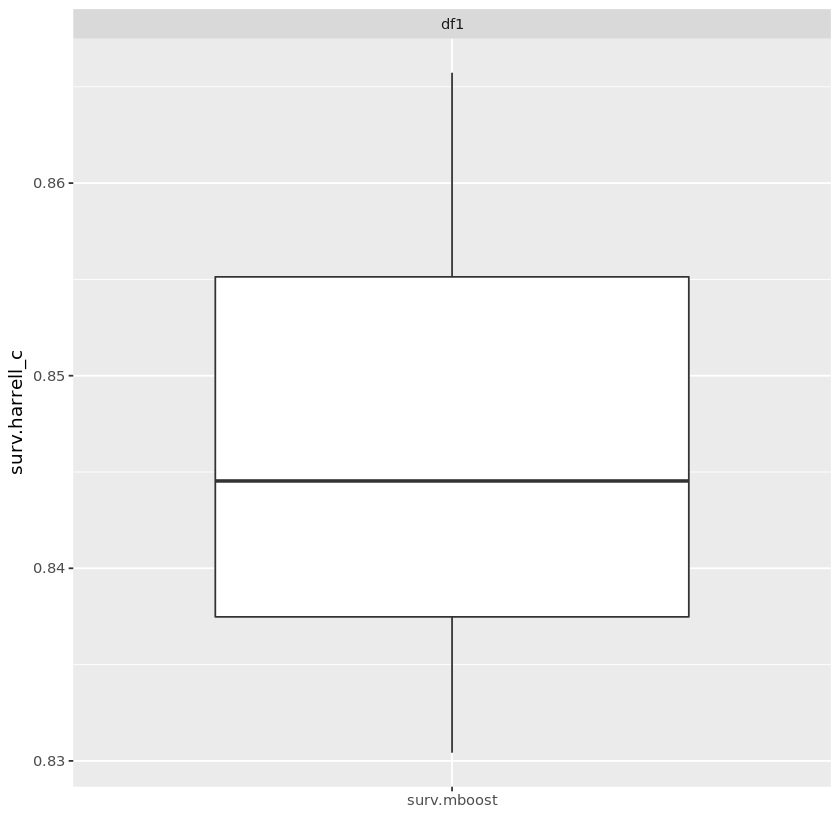

In [22]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [23]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_train_d1, grid_auto_mb, outer_rsmp, store_models = TRUE)


INFO  [21:00:52.894] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df1' (iter 3/3) 
INFO  [21:00:52.939] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [21:00:52.946] [bbotk] Evaluating 1 configuration(s) 
INFO  [21:00:52.980] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [21:00:52.994] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [21:00:54.339] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [21:00:55.916] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [21:00:57.002] [mlr3]  Finished benchmark 
INFO  [21:00:57.056] [bbotk] Result of batch 1: 
INFO  [21:00:57.059] [bbotk]  baselearner family mstop     nu surv.harrell_c 
INFO  [21:00:57.059] [bbotk]         bols cindex   112 0.1625      0.8289879 
INFO  [21:00:57.059] [bbotk]                                 uhash 
INFO  [21:00:57.059] [bbotk]  c919cfea-2701-4412-84f4-df6a91a32dfa 

In [24]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.836

surv.harrell_c 
      0.836299

In [25]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "coxph"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 112

[[1]]$nu
[1] 0.1625

Step 2_3: Autoplot the pre and after tuning boxplots

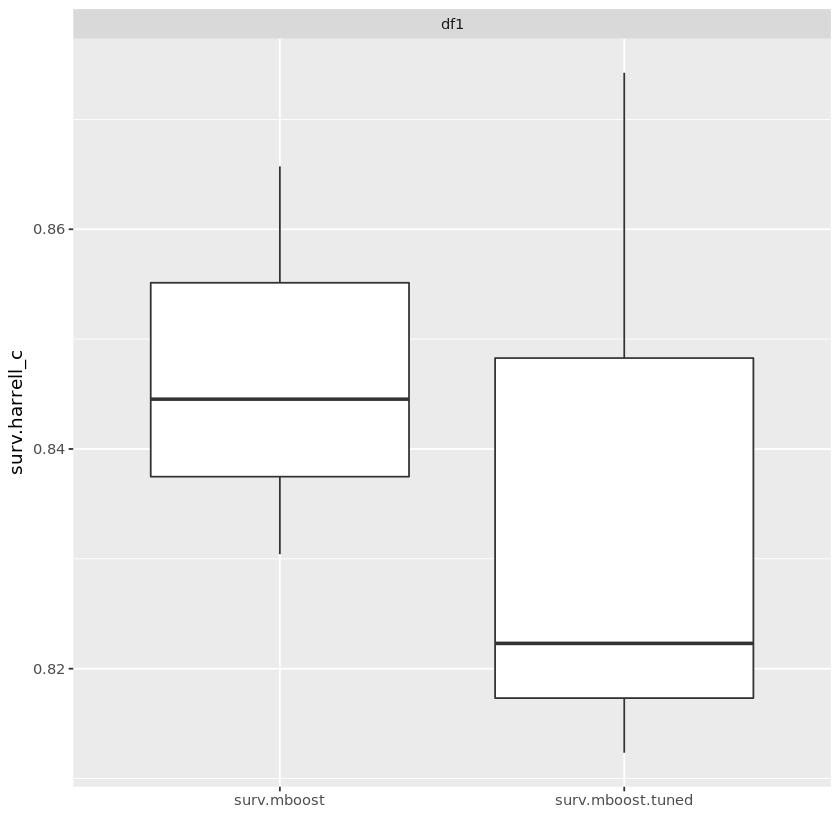

In [26]:
# autoplot the two boxplots
autoplot(c(mb_bmr, mb_bmr_2))

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [27]:
library("dataPreparation")
# Compute encoding
train_onehot_d1 <- train_data_d1
encoding <- build_encoding(train_onehot_d1, cols = c("V4"), verbose = TRUE)
# Apply one hot encoding
train_onehot_d1 <- one_hot_encoder(train_onehot_d1, encoding = encoding, drop = TRUE)
str(train_onehot_d1)

## create the corresponding task as for dataframe 1 after one-hot-encoding
tsks_oh_d1 <- TaskSurv$new("df1", backend = train_onehot_d1, time = "time", event = "status")
tsks_oh_d1

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: progress

dataPreparation 1.0.1

Type data_preparation_news() to see new features/changes/bug fixes.



[1] "build_encoding: I will compute encoding on 1 character and factor columns."
[1] "build_encoding: it took me: 0s to compute encoding for 1 character and factor columns."
[1] "one_hot_encoder: I will one hot encode some columns."
[1] "one_hot_encoder: I am doing column: V4"
[1] "one_hot_encoder: It took me 0s to transform 1 column(s)."
Classes ‘data.table’ and 'data.frame':	280 obs. of  18 variables:
 $ V1    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ time  : int  400 4500 1012 1925 1504 2503 1832 2466 2400 51 ...
 $ status: int  1 0 1 1 0 1 0 1 1 1 ...
 $ V2    : int  1 1 1 1 2 2 2 2 1 2 ...
 $ V3    : num  58.8 56.4 70.1 54.7 38.1 ...
 $ V5    : num  1 0 0.5 0.5 0 0 0 0 0 1 ...
 $ V6    : num  14.5 1.1 1.4 1.8 3.4 0.8 1 0.3 3.2 12.6 ...
 $ V7    : num  261 302 176 244 279 248 322 280 562 200 ...
 $ V8    : num  2.6 4.14 3.48 2.54 3.53 3.98 4.09 4 3.08 2.74 ...
 $ V9    : num  156 54 210 64 143 50 52 52 79 140 ...
 $ V10   : num  1718 7395 516 6122 671 ...
 $ V11   : num  137.9 113.5 96.1 

<TaskSurv:df1> (280 x 18)
* Target: time, status
* Properties: -
* Features (16):
  - dbl (11): V10, V11, V12, V13, V14, V3, V5, V6, V7, V8, V9
  - int (5): V1, V15, V2, V4.f, V4.m

Step 3_2: Try with a default setting

In [28]:
library("pracma")


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [29]:
install_learners('surv.coxboost')

In [30]:
design <- benchmark_grid(
  tasks = tsks_oh_d1,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
cb_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

cb_results <- cb_bmr$aggregate(measures = all_measures)
cb_results # 0.836

INFO  [21:12:36.225] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [21:12:36.234] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 2/3) 
INFO  [21:12:37.831] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 3/3) 
INFO  [21:12:39.400] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 1/3) 
INFO  [21:12:41.005] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x555f8dd47540>,df1,surv.coxboost,cv,3,0.8360164


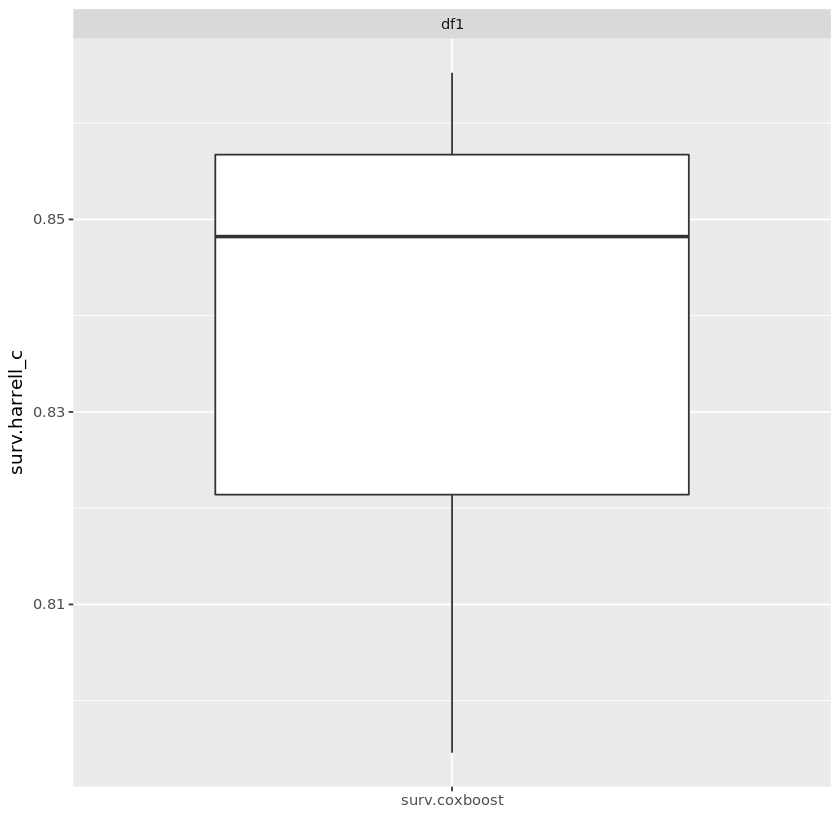

In [31]:
# plot the corresponding the performance
autoplot(cb_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [32]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 300),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)

cb_bmr_2 = resample(tsks_oh_d1, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [21:13:00.621] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df1' (iter 3/3) 
INFO  [21:13:00.655] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [21:13:00.660] [bbotk] Evaluating 1 configuration(s) 
INFO  [21:13:00.685] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [21:13:00.694] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 2/3) 
INFO  [21:13:01.573] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 1/3) 
INFO  [21:13:02.473] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 3/3) 
INFO  [21:13:03.364] [mlr3]  Finished benchmark 
INFO  [21:13:03.409] [bbotk] Result of batch 1: 
INFO  [21:13:03.411] [bbotk]  stepno penalty stepsize.factor surv.harrell_c 
INFO  [21:13:03.411] [bbotk]      50     200            5.05      0.8351288 
INFO  [21:13:03.411] [bbotk]                                 uhash 
INFO  [21:13:03.411] [bbotk]  2df5f3df-4fa2-4116-8249-3fc0ac4

In [33]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.815

surv.harrell_c 
     0.8154822

In [34]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 50

[[1]]$penalty
[1] 500

[[1]]$stepsize.factor
[1] 5.05

Step_3_4: Autoplot the pre and after tuning boxplots

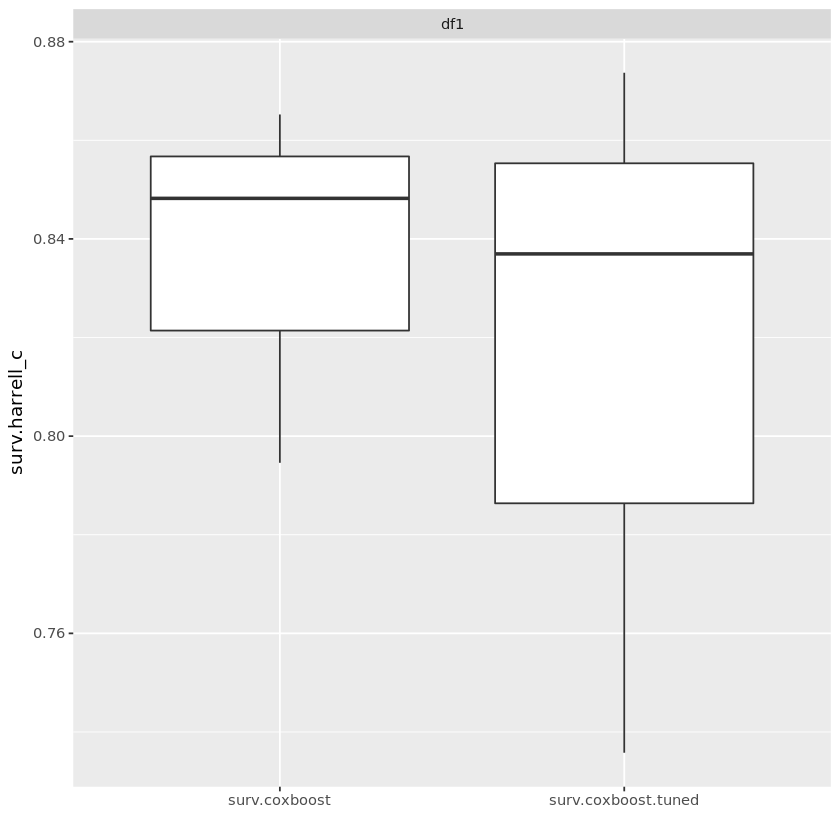

In [35]:
# autoplot the two boxplots
autoplot(c(cb_bmr, cb_bmr_2))